In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

2023-08-15 19:31:11.251659: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 19:31:11.276990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 19:31:11.726584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.data import Dataset
from random import randint

seq_len = 32
batch_size = 64

df = pd.read_csv("../data/data_iq.csv", names=["SNR", "mode", "idk", "label", *range(0, seq_len + 1)])

# last column is empty, drop it
del df[df.columns[-1]]

# convert labels to numbers
labels = {label : i for i, label in enumerate(df["label"].unique())}
for label, i in labels.items():
    df["label"].replace(label, i, inplace=True)

# group dataframes by SNR
ds_per_snr = {}
for snr in df["SNR"].unique():
    # get only rows with current SNR
    df_snr = df[df["SNR"] == snr]
    # reshape data to give I, Q their own dimension
    data = np.reshape(df_snr.iloc[:, -seq_len:], (-1, 2, seq_len))
    # create dataset from IQ data shape=(64, 2, 32)
    ds_data = Dataset.from_tensor_slices(data)
    # create dataset for labels shape=(64)
    ds_labels = Dataset.from_tensor_slices(df_snr["label"].iloc[::2])
    # pair data with label
    ds_per_snr[snr] = Dataset.zip((ds_data, ds_labels))

# randomly sample from SNR datasets to build combined dataset
ds = Dataset.sample_from_datasets(ds_per_snr.values())
# shuffle
ds = ds.shuffle(buffer_size=ds.cardinality())
# batch
ds = ds.batch(batch_size, drop_remainder=True)

train_ds, test_ds = keras.utils.split_dataset(ds, left_size=0.8, shuffle=False)
train_ds, validate_ds = keras.utils.split_dataset(train_ds, right_size=0.15, shuffle=False)

2023-08-15 19:31:14.874837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-15 19:31:14.874949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-15 19:31:14.887840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

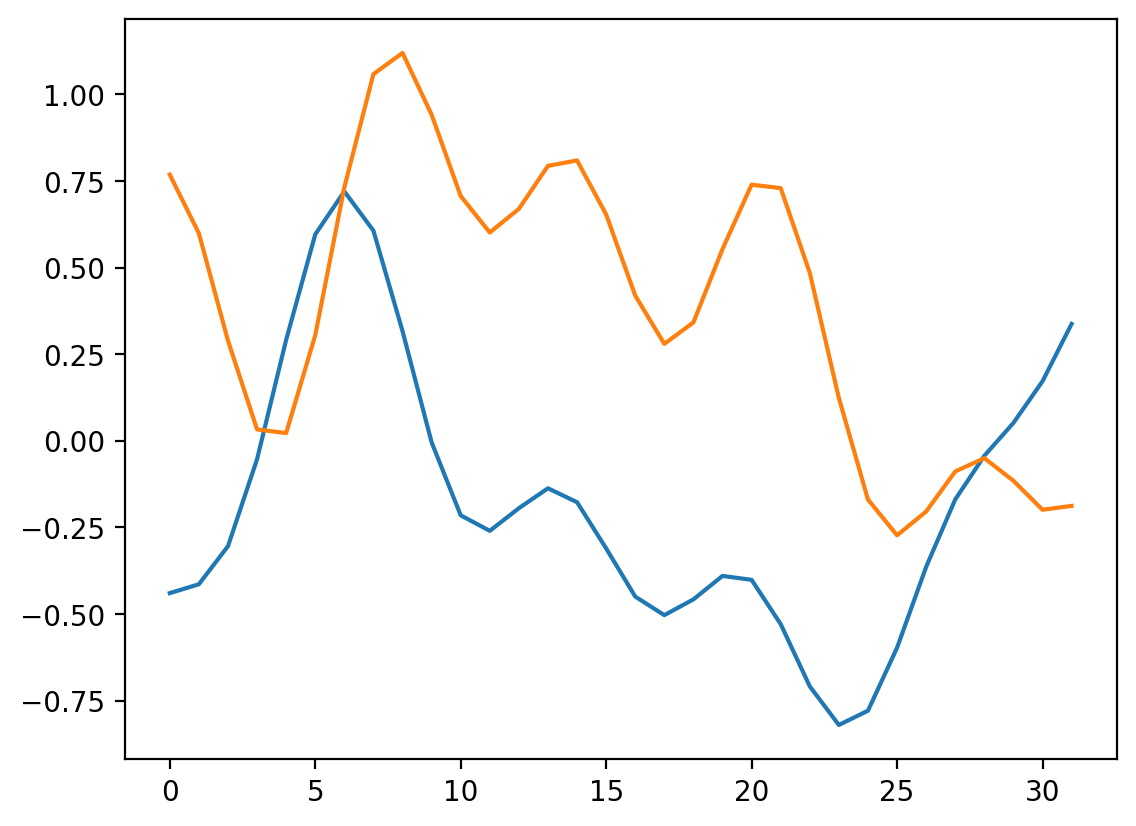

In [3]:
x, y = next(train_ds.as_numpy_iterator())
plt.plot(x[0][0])
plt.plot(x[0][1])

In [20]:
def FCN_model():
    inputs = layers.Input(shape=(2, None))
    
    # add channel dimension
    x = tf.expand_dims(inputs, axis=1)
    
    # conv layers
    x = layers.Conv2D(filters=16, kernel_size=(1, 4), strides=1, padding="same", activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization(axis=1)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(1, 4), strides=1, padding="same", activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization(axis=1)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(2, 4), strides=1, activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization(axis=1)(x)

    # x = layers.Conv2D(filters=256, kernel_size=(1, 4), strides=1, padding="same", activation="relu")(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.BatchNormalization()(x)
    
    # "fully connected" layers
    x = layers.Conv2D(filters=64, kernel_size=1, strides=1, activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.5)(x)

    # x = layers.Conv2D(filters=64, kernel_size=1, strides=1, activation="relu")(x)
    # x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(filters=3, kernel_size=1, strides=1, activation=None, data_format="channels_first")(x)
    pred = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    
    model = keras.Model(inputs=inputs, outputs=pred)
    print(model.summary())
    return model

In [22]:
model = FCN_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_ds, epochs=10, validation_data=validate_ds, validation_steps=None)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, None)]         0         
                                                                 
 tf.expand_dims_4 (TFOpLamb  (None, 1, 2, None)        0         
 da)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 2, None)       80        
                                                                 
 dropout_16 (Dropout)        (None, 16, 2, None)       0         
                                                                 
 batch_normalization_13 (Ba  (None, 16, 2, None)       64        
 tchNormalization)                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 2, None)       4160

In [23]:
for snr, ds in ds_per_snr.items():
    print(snr)
    # shuffle
    ds = ds.shuffle(buffer_size=ds.cardinality())
    # batch
    ds = ds.batch(batch_size, drop_remainder=True)
    model.evaluate(ds)
    print()

-10
93/93 [==============================] - 0s 864us/step - loss: 1.3231 - accuracy: 0.3458

-5
93/93 [==============================] - 0s 864us/step - loss: 1.1953 - accuracy: 0.3894

0
93/93 [==============================] - 0s 877us/step - loss: 0.8636 - accuracy: 0.5924

5
93/93 [==============================] - 0s 837us/step - loss: 0.3667 - accuracy: 0.8963

10
93/93 [==============================] - 0s 852us/step - loss: 0.1649 - accuracy: 0.9812

15
93/93 [==============================] - 0s 843us/step - loss: 0.1494 - accuracy: 0.9845

20
93/93 [==============================] - 0s 830us/step - loss: 0.1456 - accuracy: 0.9866

25
93/93 [==============================] - 0s 817us/step - loss: 0.1490 - accuracy: 0.9856



In [7]:
model.evaluate(test_ds)

150/150 [==============================] - 0s 945us/step - loss: 0.5442 - accuracy: 0.7716


[0.5442101359367371, 0.7715625166893005]

In [ ]:
# epochs = 6
# criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)

# for epoch in range(epochs):
#     print(f"\nStart of epoch {epoch}")
#     for step, (inputs, labels) in enumerate(train_gen):
#         with tf.GradientTape() as tape:
#             logits = model(inputs, training=True)
#             loss = criterion(labels, logits)
#         grads = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))
#         if not step % 500:
#             print(f"Training loss: {float(loss)}")

In [17]:
# from mltk.core import train_model
# training_results = train_model('image_example1', epochs=10, show=True)

In [24]:
import mltk.core as mltk_core 

def FCN_model():
    inputs = layers.Input(shape=(2, None))
    
    # add channel dimension
    x = tf.expand_dims(inputs, axis=1)
    
    # conv layers
    x = layers.Conv2D(filters=16, kernel_size=(1, 4), strides=1, padding="same", activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization(axis=1)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(1, 4), strides=1, padding="same", activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization(axis=1)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(2, 4), strides=1, activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization(axis=1)(x)

    # x = layers.Conv2D(filters=256, kernel_size=(1, 4), strides=1, padding="same", activation="relu")(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.BatchNormalization()(x)
    
    # "fully connected" layers
    x = layers.Conv2D(filters=64, kernel_size=1, strides=1, activation="relu", data_format="channels_first")(x)
    x = layers.Dropout(0.5)(x)

    # x = layers.Conv2D(filters=64, kernel_size=1, strides=1, activation="relu")(x)
    # x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(filters=3, kernel_size=1, strides=1, activation=None, data_format="channels_first")(x)
    pred = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    
    model = keras.Model(inputs=inputs, outputs=pred)
    print(model.summary())
    return model

class MyModel(
    mltk_core.MltkModel,
    mltk_core.TrainMixin,
    mltk_core.DatasetMixin,
    mltk_core.EvaluateClassifierMixin,
):
    pass

my_model = MyModel()

def my_model_builder(mltk_model):
    model = FCN_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model

def my_dataset_loader(subset, test, **kwargs):
    if subset == "training":
        return train_ds, None, validate_ds
    else:
        return test_ds

def my_representative_dataset_generator():
    for input_value in Dataset.from_tensor_slices(my_model.x).batch(1).take(100):
        yield [input_value]

my_model.build_model_function = my_model_builder
my_model.dataset = my_dataset_loader
my_model.epochs = 10
my_model.batch_size = batch_size
# my_model.classes = ["BLE", "Zigbee", "Noise"]
my_model.tflite_converter["representative_dataset"] = my_representative_dataset_generator

if __name__ == "__main__":
    from mltk import cli
    cli.get_logger(verbose=False)

    train_results = mltk_core.train_model(my_model, clean=True, create_archive=False)
    print(train_results)

    tflite_eval_results = mltk_core.evaluate_model(my_model, verbose=True)
    print(tflite_eval_results)

#     profiling_results = mltk_core.profile_model(my_model)
#     print(profiling_results)


Cleaning all files in /home/arsem/.mltk/models/3802132188
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, None)]         0         
                                                                 
 tf.expand_dims_5 (TFOpLamb  (None, 1, 2, None)        0         
 da)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 2, None)       80        
                                                                 
 dropout_20 (Dropout)        (None, 16, 2, None)       0         
                                                                 
 batch_normalization_16 (Ba  (None, 16, 2, None)       64        
 tchNormalization)                                               
                                                                 
 

ValueError: Failed to quantize model, Failed to quantize model, Slicing dataset elements is not supported for rank 0.